# Report of COMEXT import/export dataset

This report contains some sumamry statistics and graphs relating to the COMEXT dataset about import/export exchanges between countries. 
The steps that were done before the analysis are the following:
- combine I/E when regarding the same edge, with the mean;
- normalization by populationat each year (UN dataset), thus defining € pro capite as values;
- for every month, for every prod category, compute metrics graph-level and node-level;
- visual analysis of the network;
- AR Networks paper

## Code and functions

In [83]:
#@title Code and functions
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q -r comext_graph_analysis/requirements.txt

import random, math, os, pickle, sys, powerlaw #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from networkx.readwrite import json_graph
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler

sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/COMEXT


In [2]:
df_pop, eu_iso = g.load_population_df()
full_metrics_df = pd.read_parquet("./data-samples/manual/metrics/metrics_full_v9_2.parquet")

## Population analysis

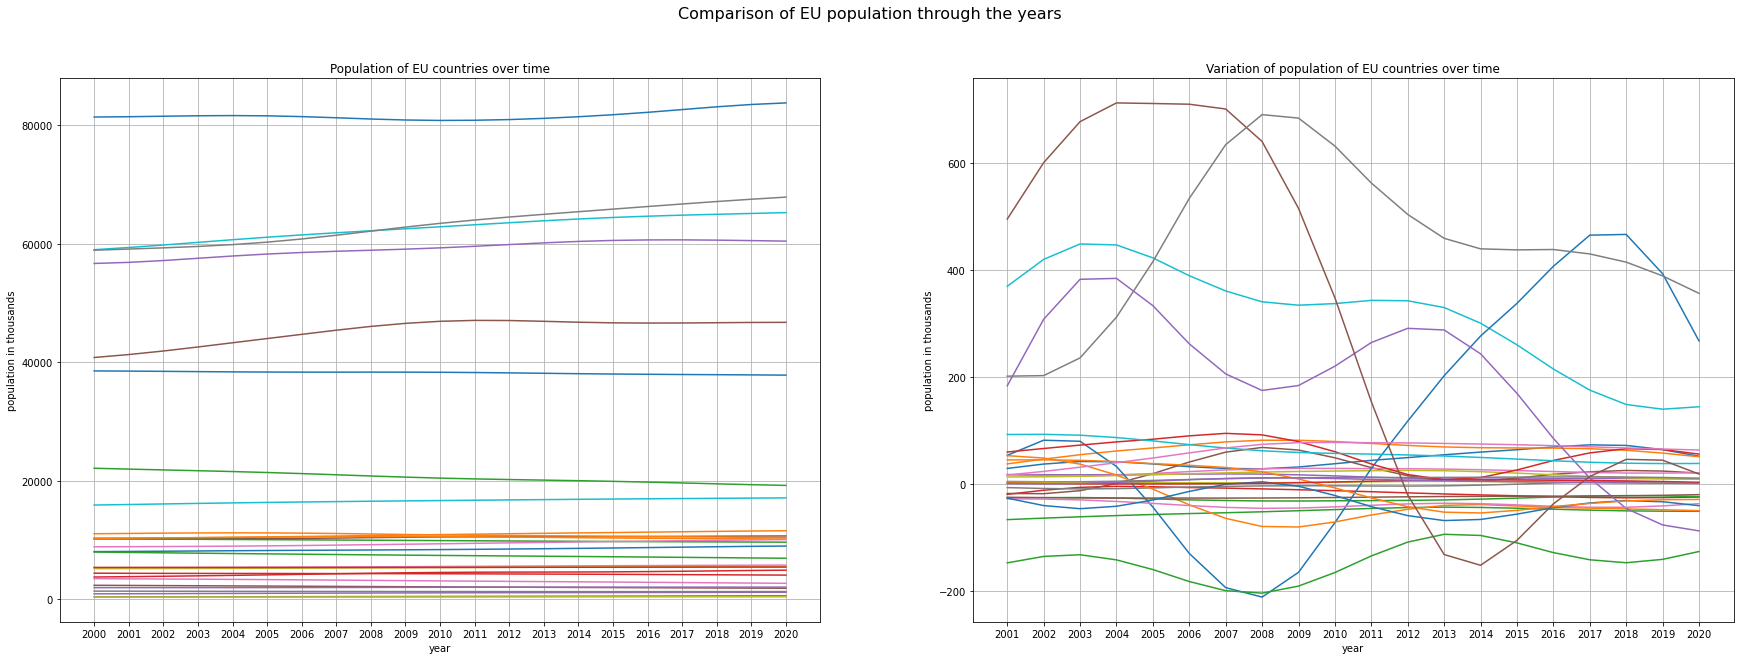

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.plot(df_pop.loc[eu_iso,:].transpose())
ax1.set_title("Population of EU countries over time")
ax1.set_ylabel("population in thousands")
ax1.set_xlabel("year")
ax1.grid()
# ax1.legend(loc="upper right")
ax2.plot(df_pop.diff(periods=1,axis=1).loc[eu_iso,:].transpose())
ax2.set_title("Variation of population of EU countries over time")
ax2.set_ylabel("population in thousands")
ax2.set_xlabel("year")
ax2.grid()
# ax2.legend(loc="upper right")
plt.suptitle("Comparison of EU population through the years",fontsize=16)
plt.show()

## Price analysis (general)

In [4]:
df_full, _ = g.load_filtered_data("full",save=True, force_reload=False, types=g.full_types, columns=g.full_columns, group_by_prod_code=True, n_digits=2,
                             years=[2021], months=None, product=["TOTAL"], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
df_full["PRICE"] = df_full["VALUE_IN_EUROS"] / df_full["QUANTITY_IN_KG"]

loading full: loading existing... Table loaded


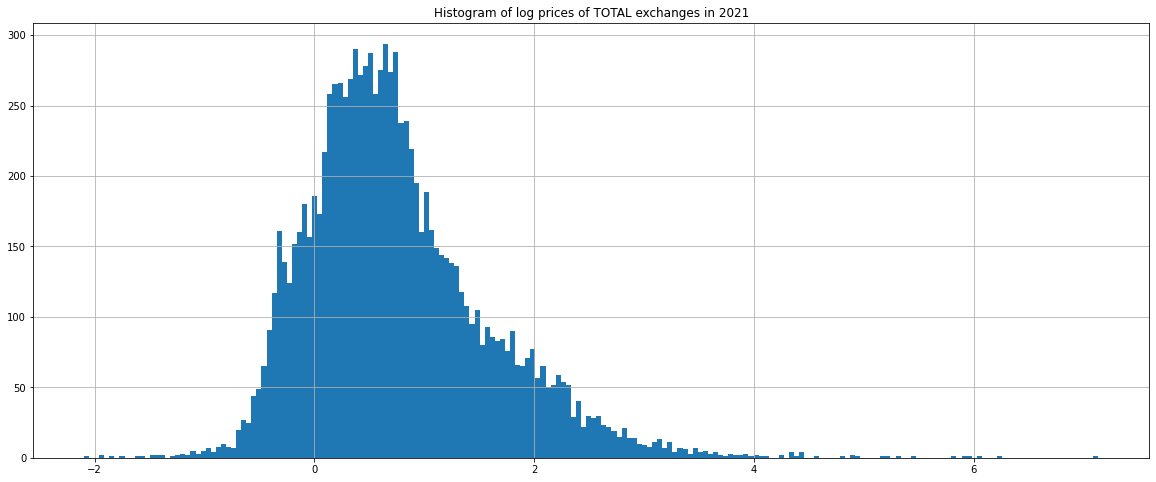

In [5]:
np.log10(df_full[(df_full.VALUE_IN_EUROS > 0)&(df_full.QUANTITY_IN_KG > 0)].PRICE).hist(bins=200,figsize=(20,8))
plt.title("Histogram of log prices of TOTAL exchanges in 2021")
plt.show()

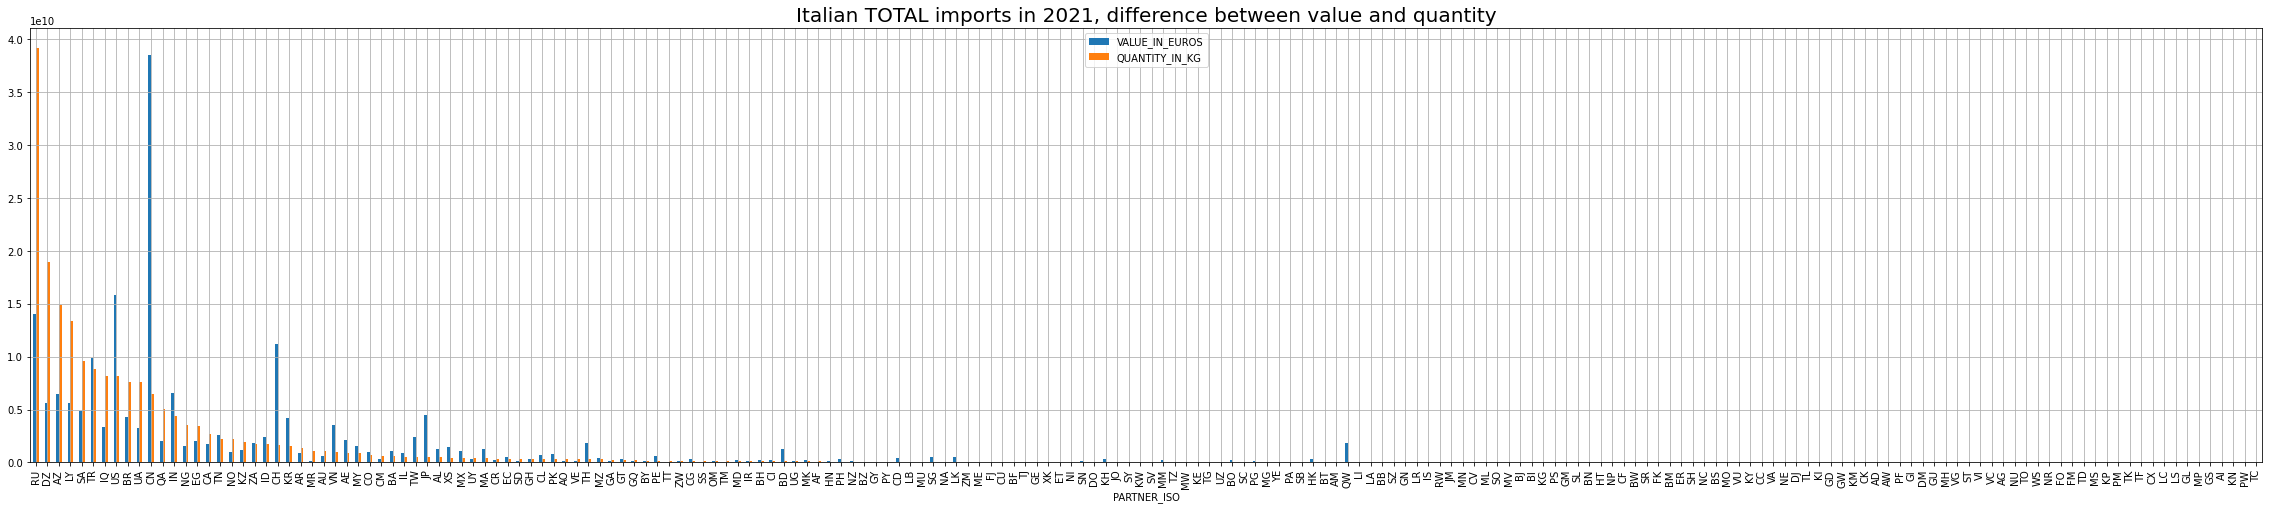

In [6]:
df_full[(df_full.FLOW==1)&(df_full.DECLARANT_ISO=="IT")][["PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]].set_index("PARTNER_ISO").plot.bar(figsize=(40,8))
plt.title("Italian TOTAL imports in 2021, difference between value and quantity",fontsize=20)
plt.legend(loc="upper center")
plt.grid()
plt.show()

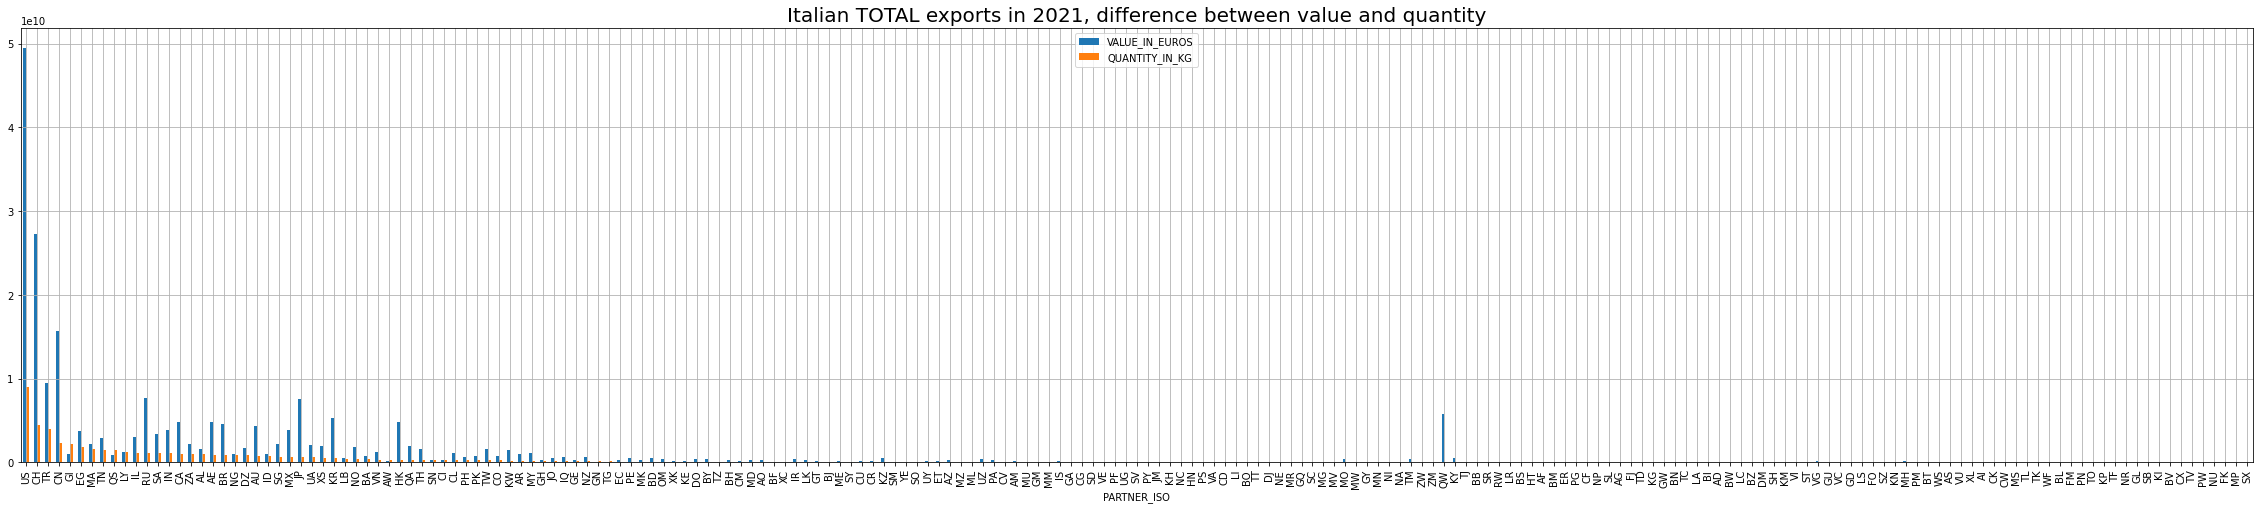

In [7]:
df_full[(df_full.FLOW==2)&(df_full.DECLARANT_ISO=="IT")][["PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]].set_index("PARTNER_ISO").plot.bar(figsize=(40,8))
plt.title("Italian TOTAL exports in 2021, difference between value and quantity",fontsize=20)
plt.legend(loc="upper center")
plt.grid()
plt.show()

## Threshold Analysis

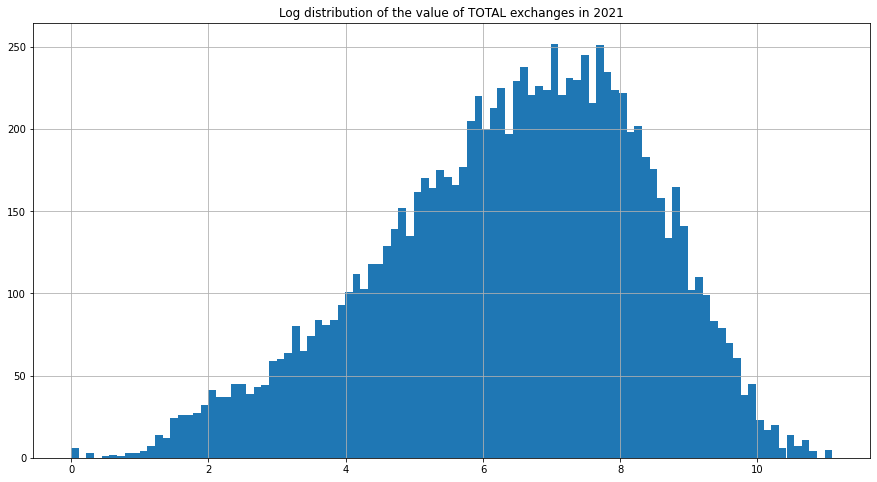

In [8]:
plt.figure(figsize=(15,8))
plt.hist(np.log10(df_full.VALUE_IN_EUROS[df_full.VALUE_IN_EUROS >0]),bins=100)
plt.title("Log distribution of the value of TOTAL exchanges in 2021")
plt.grid()
plt.show()

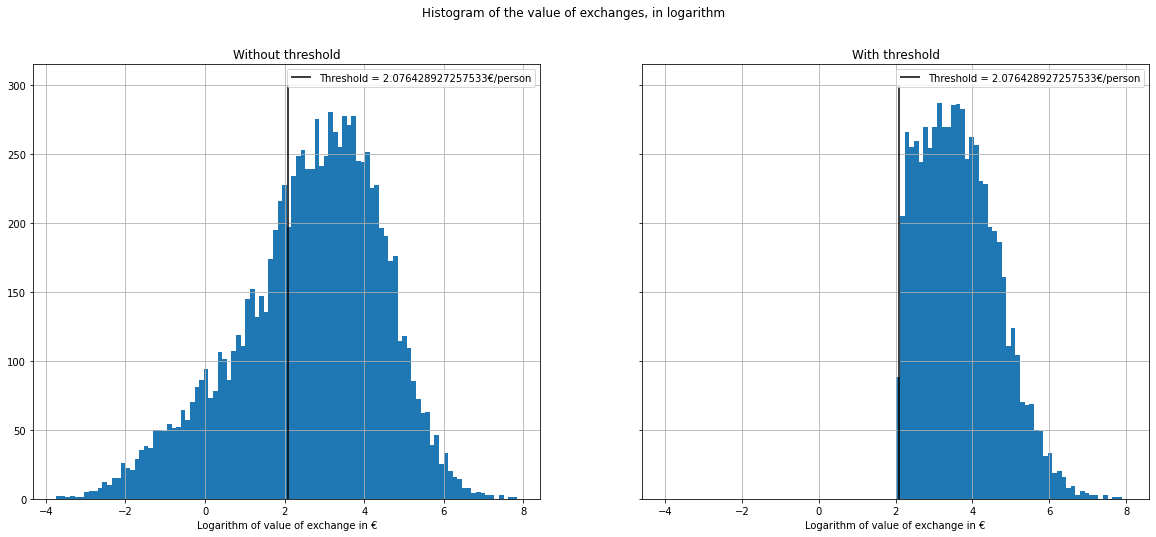

In [9]:
df_full_scaled = g.extract_table_for_graph(df_full, y="2021", flow="all", scale_by="population")
df7 = df_full_scaled.sort_values("VALUE_IN_EUROS_SCALED",ascending=False).reset_index(drop=True)
df7 = df7[df7.VALUE_IN_EUROS_RESCALED.cumsum() < 0.9999]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8),sharey=True)
ax1.hist(np.log10(df_full_scaled.VALUE_IN_EUROS_SCALED[df_full_scaled.VALUE_IN_EUROS_SCALED > 0]),bins=100)
ax1.vlines(np.log10(df7.iloc[-1,-4]),0,300,label=f"Threshold = {np.log10(df7.iloc[-1,-4])}€/person")
ax1.set_xlabel("Logarithm of value of exchange in €")
ax1.set_title("Without threshold")
ax1.legend()
ax1.grid()
ax2.hist(np.log10(df7.VALUE_IN_EUROS_SCALED[df7.VALUE_IN_EUROS_SCALED > 0]),bins=100,range=(-4,8))
ax2.vlines(np.log10(df7.iloc[-1,-4]),0,300,label=f"Threshold = {np.log10(df7.iloc[-1,-4])}€/person")
ax2.set_xlabel("Logarithm of value of exchange in €")
ax2.set_title("With threshold")
ax2.grid()
ax2.legend()
plt.suptitle("Histogram of the value of exchanges, in logarithm")
plt.show()

Before thresholding the distribution was as above, with a considerable number of left tail values that are very low. After rescaling the values get truncated to the left with a cutoff of around 10 euro pro capite

In [10]:
# Thresholding by quantile
q = 0.05
print("Threshold value at", 10**np.log10(df_full_scaled.VALUE_IN_EUROS_SCALED[df_full_scaled.VALUE_IN_EUROS_SCALED>0]).quantile(q))
print("Actual:",end=" ")
df_full_scaled[df_full_scaled.VALUE_IN_EUROS_SCALED > df_full_scaled.VALUE_IN_EUROS_SCALED.quantile(q)].sort_values("VALUE_IN_EUROS_SCALED",ascending=False).iloc[-1,-4]

Threshold value at 0.14541471251715213
Actual: 

0.1460104545704958

In [11]:
# Thresholding by cumsum
df7 = df_full_scaled.sort_values("VALUE_IN_EUROS_SCALED",ascending=False).reset_index(drop=True)
print("Threshold value at:",end=" ")
df7[df7.VALUE_IN_EUROS_RESCALED.cumsum() < 0.999].iloc[-1,-4]

Threshold value at: 

912.2627242849529

## Analysis of graph metrics across categories

### Mean Density across time

#### Functions

In [41]:
def node_metrics_ts(metrics_df, node, prod=None):
    if prod is None:
        prod = "TO"
    if node != "world":
        return metrics_df[(metrics_df.country == node)&(metrics_df["prod"]==prod)].reset_index(drop=True).copy()
    else:
        fmdf_gr = full_metrics_df.groupby(["year","month","prod"],as_index=False).sum()
        return fmdf_gr[fmdf_gr["prod"] == prod].reset_index(drop=True).copy()

def plot_cat_ts(metrics_df, prod=None, metr="density", country="IT", moving_avg=None, log=False):
    df = node_metrics_ts(metrics_df,node=country,prod=prod)
    df["date"] = df.year + df.month
    df.set_index("date",inplace=True)
    title = metr.capitalize() + " of " + country + " for " + g.get_cat_name("full","06") + " from 2001 to 2021"
    if moving_avg is None:
        if log:
            np.log10(df[[metr]]).plot(figsize=(20,8),label=metr)
            title = "Log " + title 
        else:
            df[[metr]].plot(figsize=(20,8),label=metr)
    else:
        if log:
            df['MA'] = np.log10(df[metr]).rolling(window=moving_avg).mean()
            title = "Log " + title + ", with rolling average of " + str(moving_avg) + " months"
        else:
            df['MA'] = df[metr].rolling(window=moving_avg).mean()
            title += ", with rolling average of " + str(moving_avg) + " months"
        df.MA.plot(figsize=(20,8),label=metr)
    plt.legend()
    plt.ylabel(metr)
    plt.title(title,fontsize=14)

def plot_bar_metr(metrics_df,country="IT",metr="density",log=False):
    ita_in = metrics_df[(metrics_df.country == country)]
    # ita_in = metrics_df[(metrics_df.country == "IT")]
    ita_pivot = ita_in[["year","month","prod",metr]].reset_index(drop=True).pivot(index=["year","month"], columns=["prod"])
    if not log:
        ita_pivot.mean(axis=0).reset_index(level=0,drop=True).rename({i:i+" "+g.get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).plot.bar(figsize=(20,8))
        plt.ylabel(metr)
    else:
        np.log10(ita_pivot.mean(axis=0)).reset_index(level=0,drop=True).rename({i:i+" "+g.get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).plot.bar(figsize=(20,8))
        plt.ylabel("log "+metr)
    # plt.xticks(rotation=45, rotation_mode="anchor", position=(0.1,-0.11))
    plt.axhline(y=0,color="k",linewidth=0.5)
    plt.title("Mean "+metr+" across time for "+country)

def plot_power_law(metr_df,metric):
    y, x = np.histogram(metr_df[metric],bins=200,density=True)
    x = np.array([np.mean([x[i],x[i+1]]) for i in range(len(x)-1)])
    x = x[y > 0]
    y = y[y > 0]
    x_log = np.log10(x)
    y_log = np.log10(y)
    results = powerlaw.Fit(metr_df[metric].to_numpy(),xmin=1.)
    print("Power law degree is:", results.power_law.alpha)
    ## Graph
    l = np.linspace(np.min(x),np.max(x))
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
    # ax1
    ax1.plot(l,l**(-results.power_law.alpha),color="r",label=f"powerlaw, gamma = {results.power_law.alpha:.4}")
    ax1.scatter(x,y,label=metric+" distribution")
    ax1.set_xlabel(metric)
    ax1.set_ylabel("P("+metric+")")
    ax1.legend()
    # ax2
    l = np.linspace(np.min(x_log),np.max(x_log))
    ax2.plot(l,l*(-results.power_law.alpha),color="r",label=f"powerlaw, gamma = {results.power_law.alpha:.4}")
    ax2.scatter(x_log,y_log,label=metric+" distribution")
    ax2.set_xlabel("log("+metric+")")
    ax2.set_ylabel("log( P("+metric+") )")
    ax2.legend()

    plt.suptitle("Power Law fit of "+metric+" in 01/2021",fontsize=16)
    plt.show()

#### Category Time series

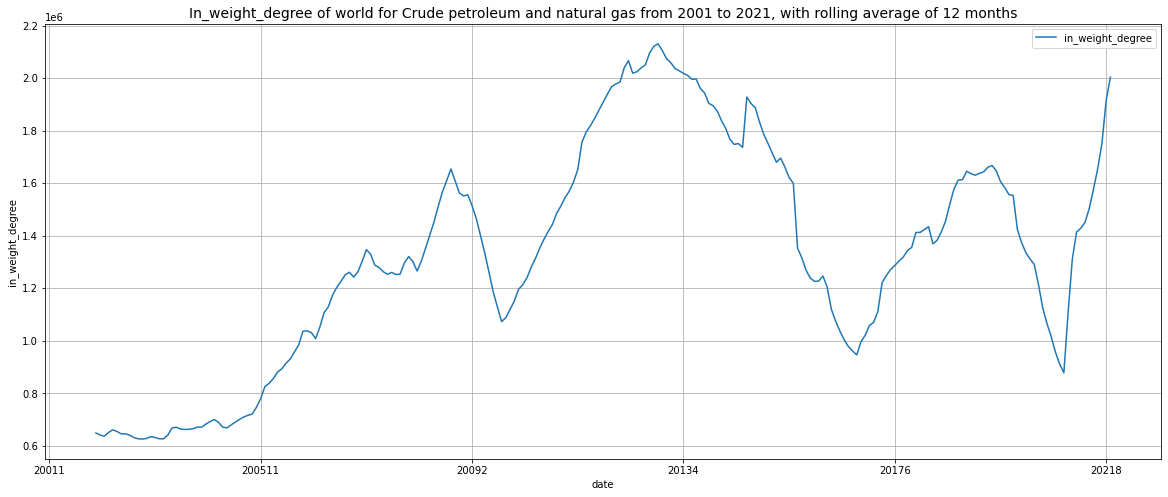

In [13]:
g.plot_cat_ts(full_metrics_df, metr="in_weight_degree", prod="06", moving_avg=12)

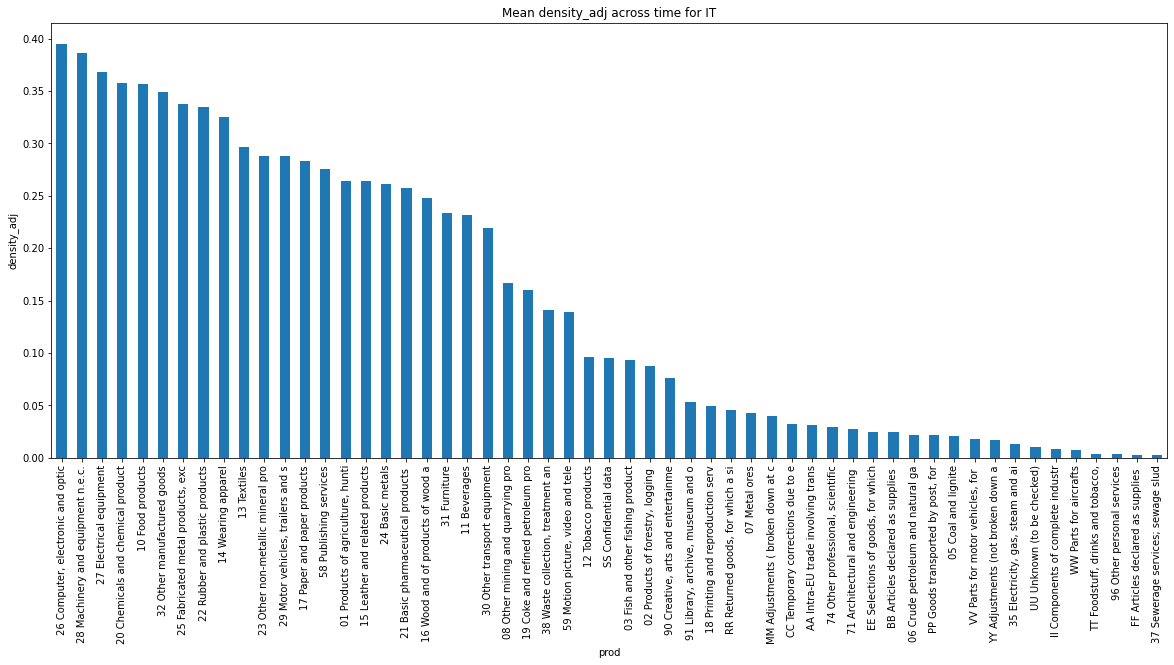

In [14]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="density_adj",log=False)

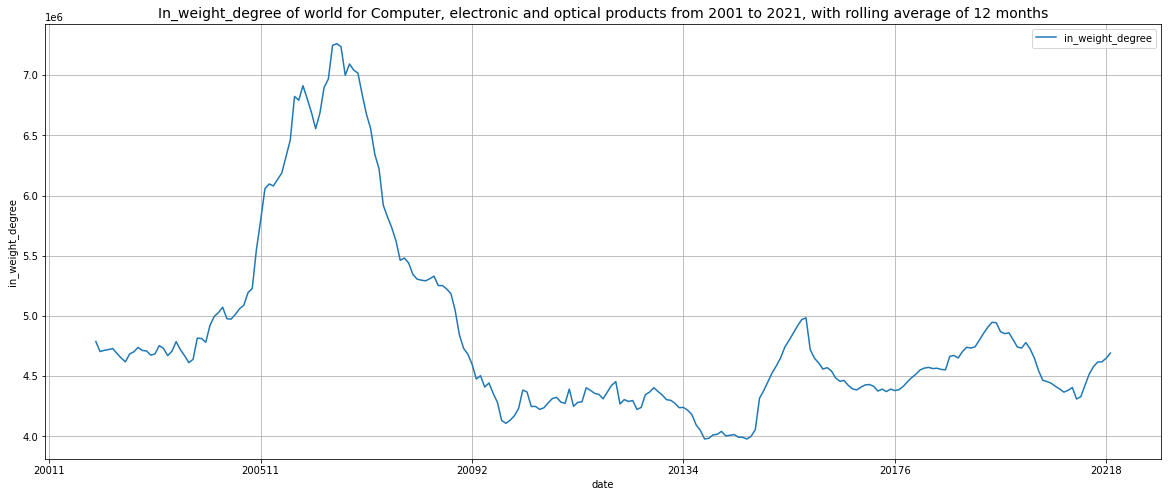

In [15]:
g.plot_cat_ts(full_metrics_df, metr="in_weight_degree", prod="26", moving_avg=12)

### Power law

In [34]:
metrics_TO_21_01 = full_metrics_df[(full_metrics_df["prod"] == "TO")&(full_metrics_df.year == "2021")&(full_metrics_df.month == "1")]
metrics_TO_21_01_avg = metrics_TO_21_01.groupby(["year","prod","country"],as_index=False).mean().set_index("country")

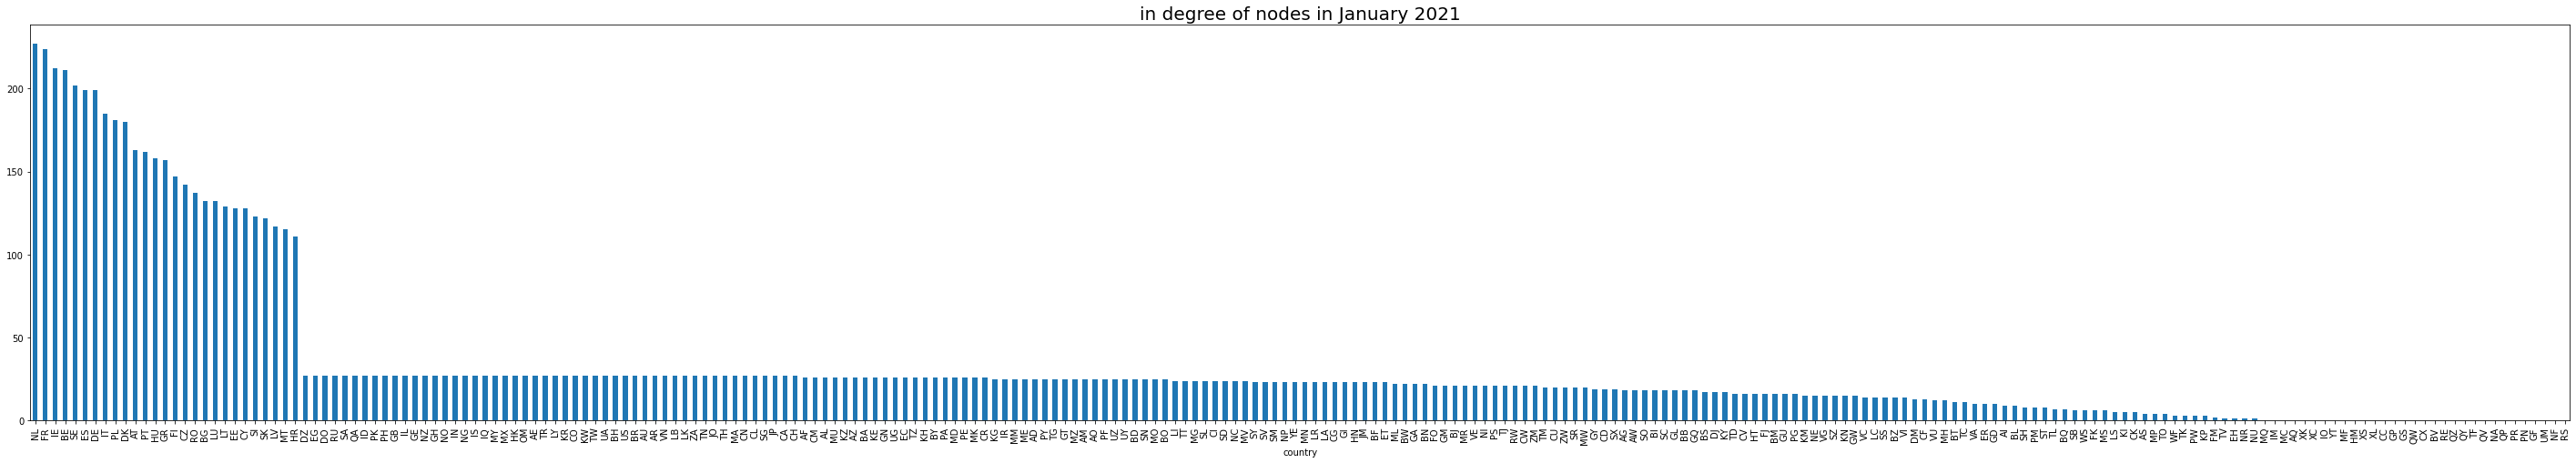

In [35]:
metrics_TO_21_01_avg.in_degree.sort_values(ascending=False).plot.bar(figsize=(50,8))
plt.xticks(rotation=90)
plt.title("in degree of nodes in January 2021",fontsize=20)
plt.show()

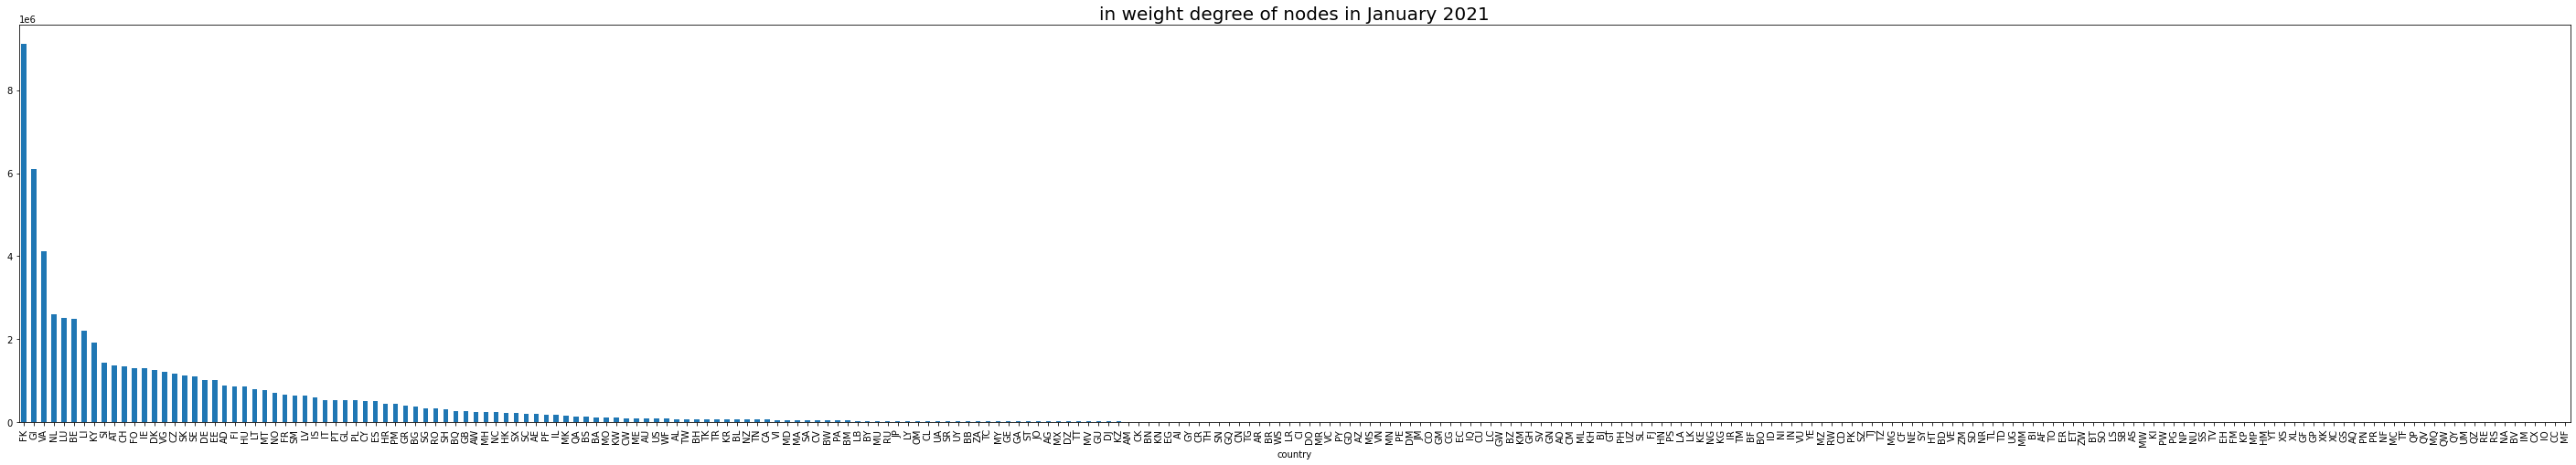

In [36]:
metrics_TO_21_01_avg.in_weight_degree.sort_values(ascending=False).plot.bar(figsize=(50,8))
plt.xticks(rotation=90)
plt.title("in weight degree of nodes in January 2021",fontsize=20)
plt.show()

Possible Question:

How can we define dependence by looking at in degree and in weight degreee?
There are countries who import a lot but from a single supplier or countries that import from a lot of suppliers but a smaller quantity. How do we intergrate the two?

IDEA: look at stacked bar plot with percentages.
However, it's just qualitative. 

POWERLAW.FIT:

Returns the optimal xmin beyond which the scaling regime of the power
        law fits best. The attribute self.xmin of the Fit object is also set.
        The optimal xmin beyond which the scaling regime of the power law fits
        best is identified by minimizing the Kolmogorov-Smirnov distance
        between the data and the theoretical power law fit.
        This is the method of Clauset et al. 2007.

##### Degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.2795748409631438


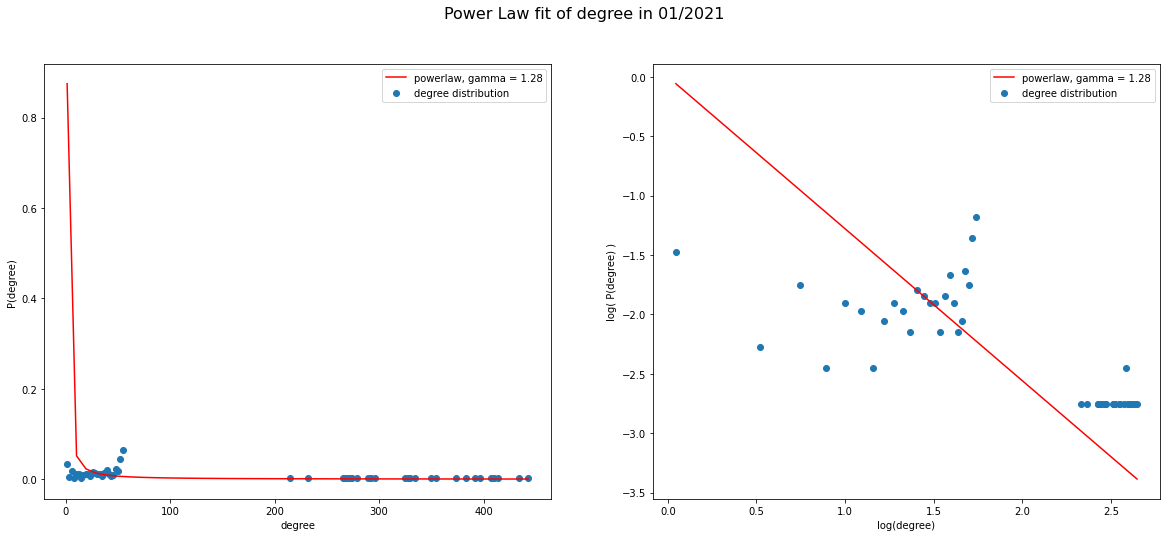

In [42]:
plot_power_law(metrics_TO_21_01_avg,"degree")

##### In degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.3194626532308127


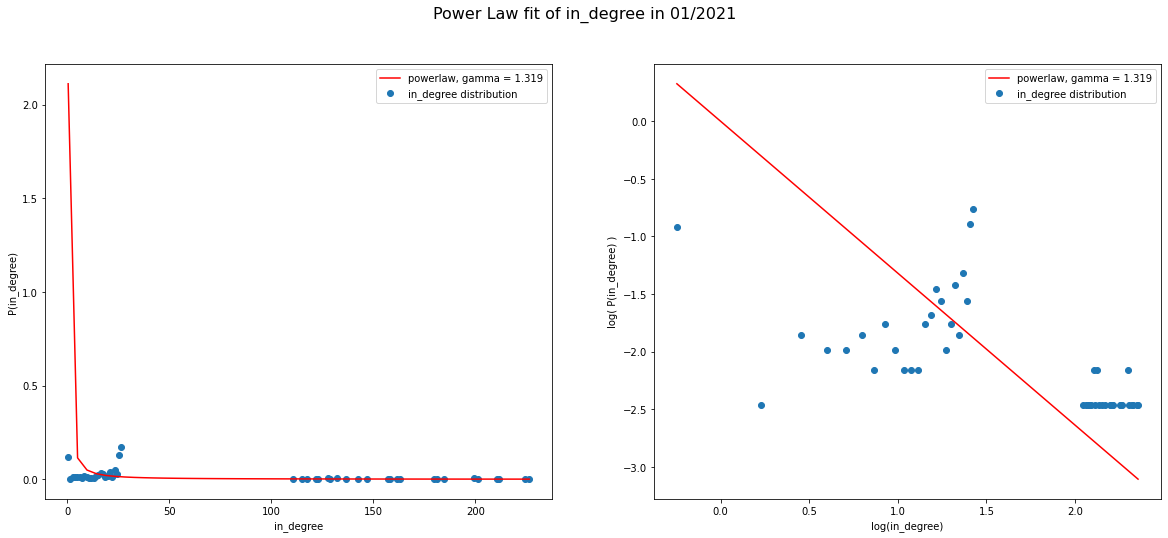

In [43]:
plot_power_law(metrics_TO_21_01_avg,"in_degree")

##### In weight degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.1012386061223112


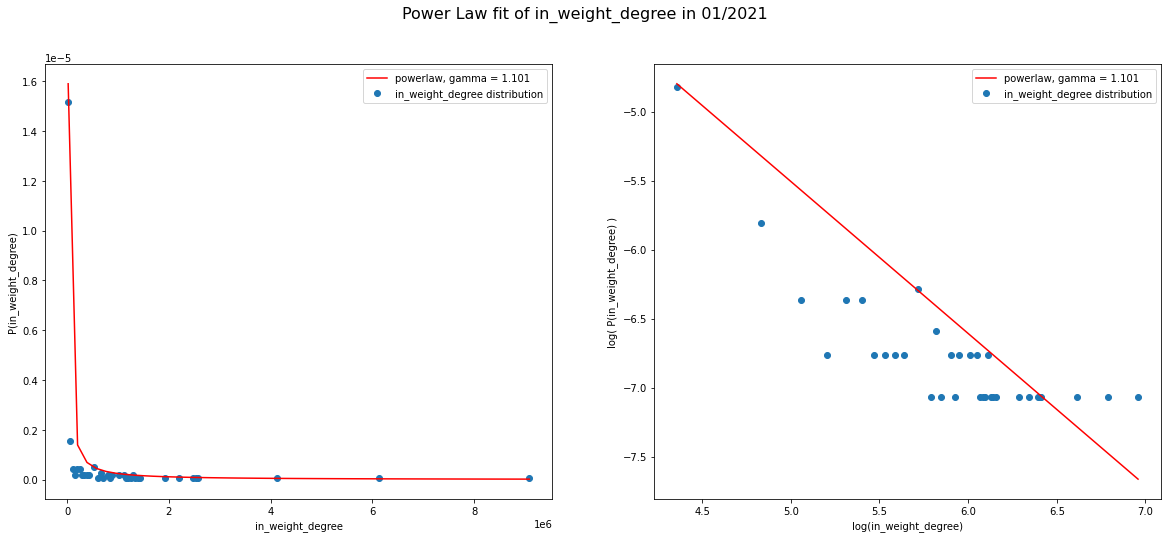

In [44]:
plot_power_law(metrics_TO_21_01,"in_weight_degree")

##### Out degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.3460976416944388


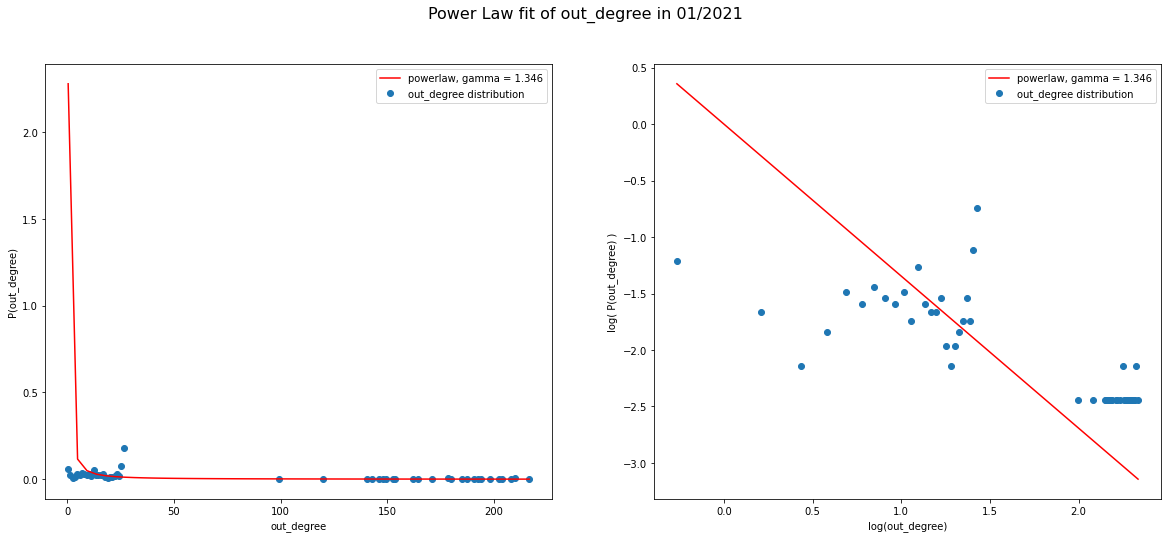

In [46]:
plot_power_law(metrics_TO_21_01_avg,"out_degree")

#### Out weight degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.126024716010988


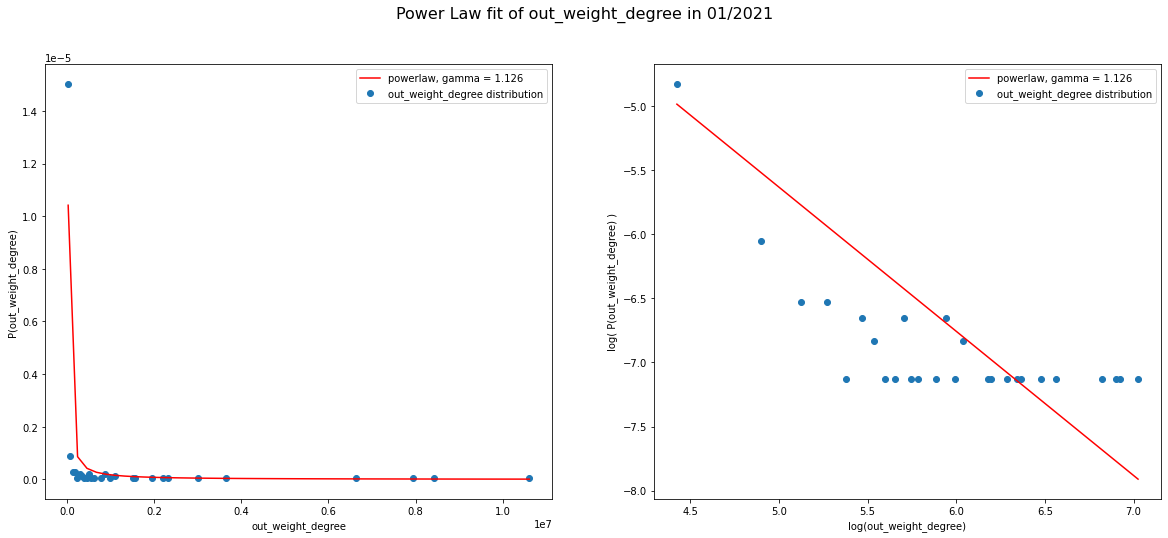

In [47]:
plot_power_law(metrics_TO_21_01_avg,"out_weight_degree")

## Analysis for ITALY

Next I'll do an analysis following Italy's import/export through time

In [48]:
ita_in = full_metrics_df[(full_metrics_df.country == "IT")&(full_metrics_df["prod"] != "TO")]

In [50]:
ita_pivot = ita_in[["year","month","prod","in_weight_degree"]].reset_index(drop=True).pivot(index=["year","month"], columns=["prod"]).droplevel(0,1)

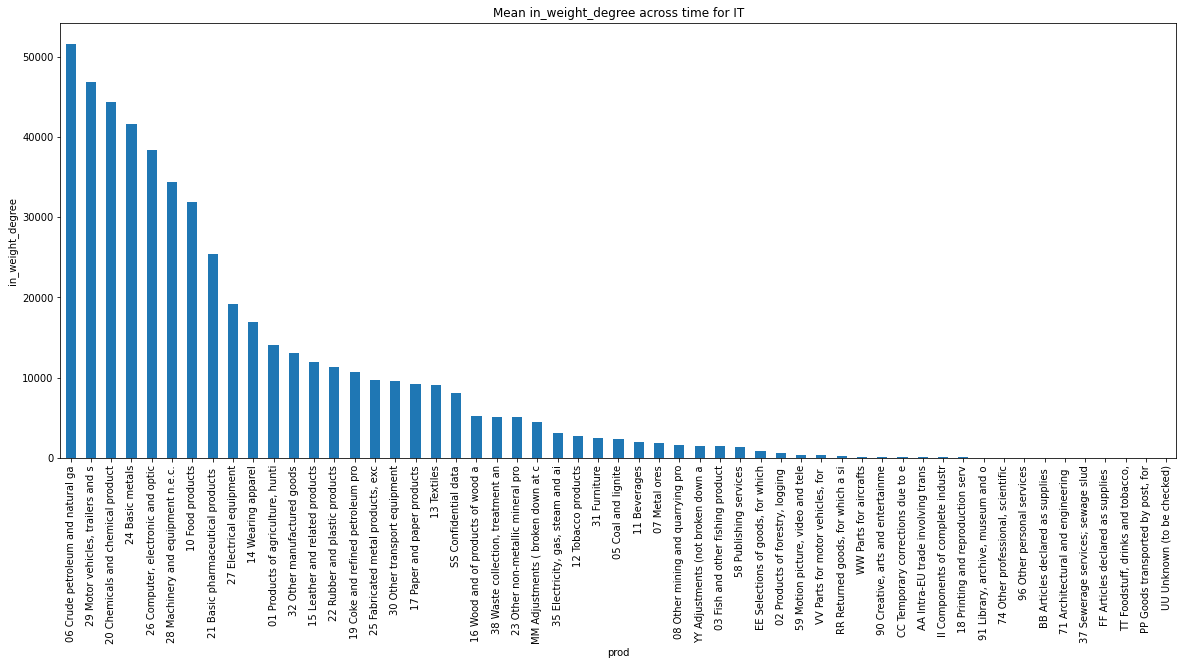

In [52]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="in_weight_degree",log=False)

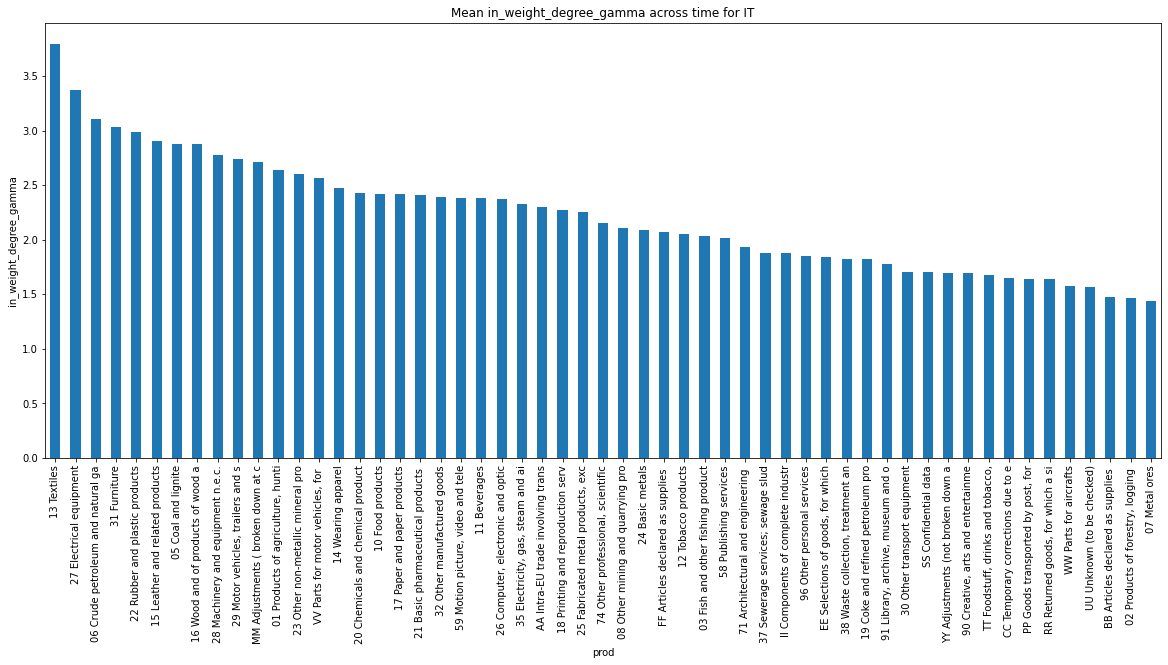

In [56]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="in_weight_degree_gamma",log=False)

### Metrics plot ts

In [57]:
df_full_06 = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[y for y in range(2001,2022)], months="all", product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded


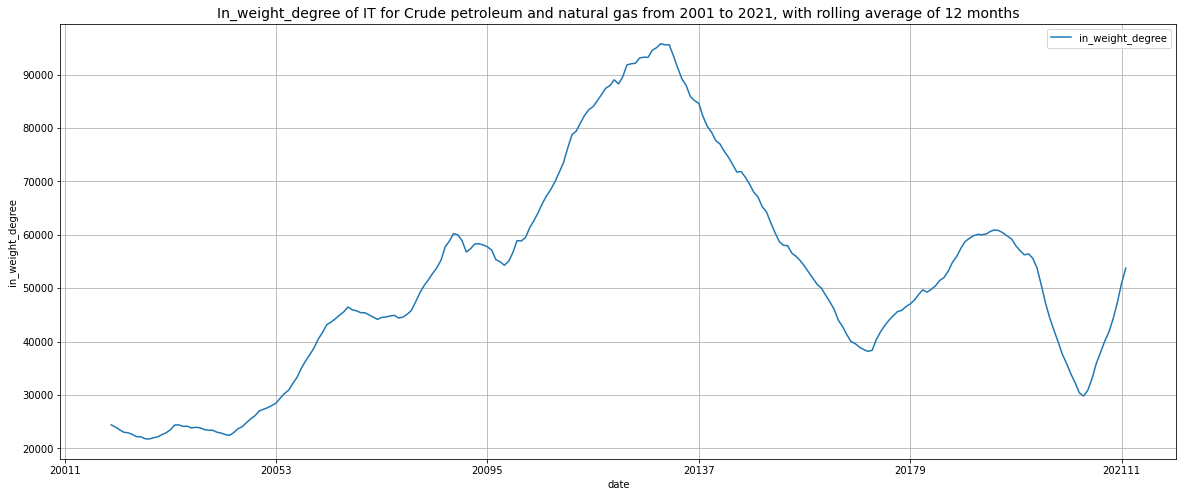

In [59]:
g.plot_cat_ts(full_metrics_df,"06","in_weight_degree","IT",moving_avg=12,log=False)

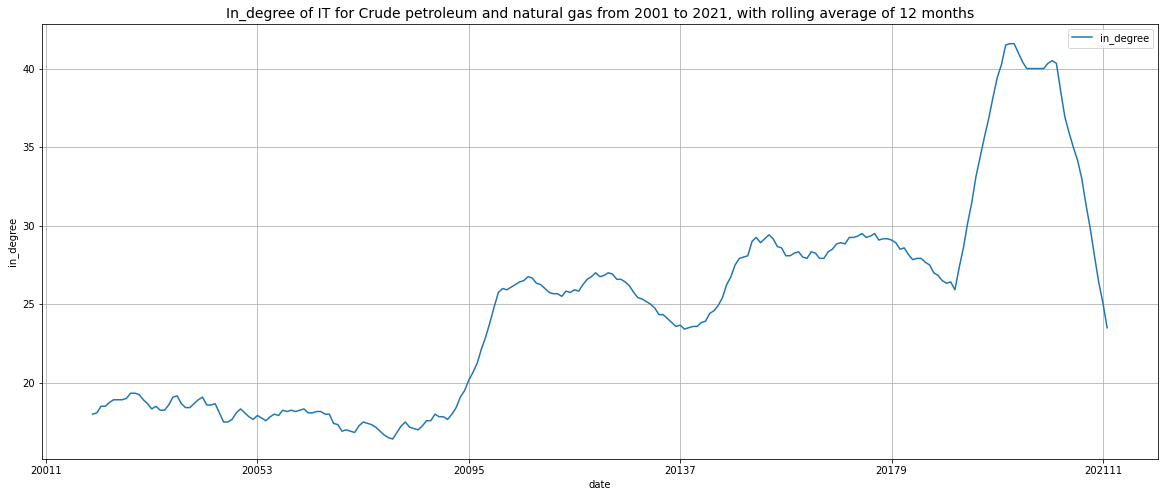

In [61]:
g.plot_cat_ts(full_metrics_df,"06","in_degree","IT",moving_avg=12)

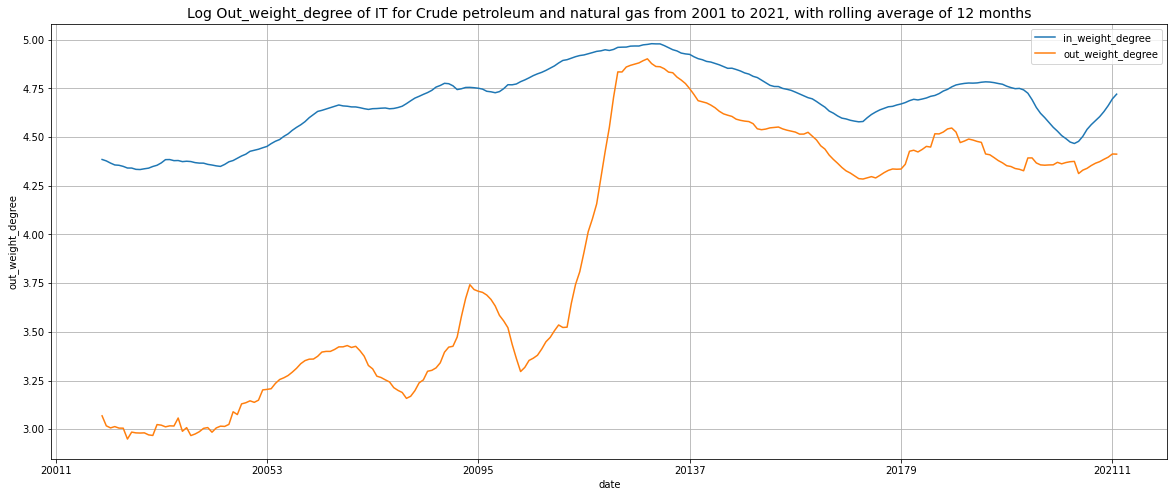

In [62]:
g.plot_cat_ts(full_metrics_df,"06","in_weight_degree","IT",moving_avg=12,log=True)
g.plot_cat_ts(full_metrics_df,"06","out_weight_degree","IT",moving_avg=12,log=True)

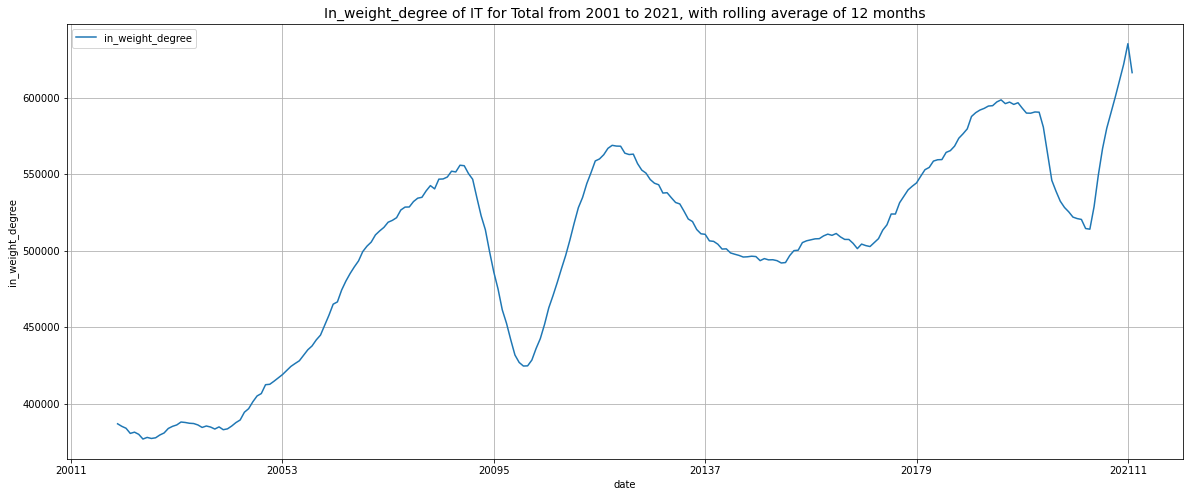

In [65]:
g.plot_cat_ts(full_metrics_df,"TO","in_weight_degree","IT",moving_avg=12,log=False)

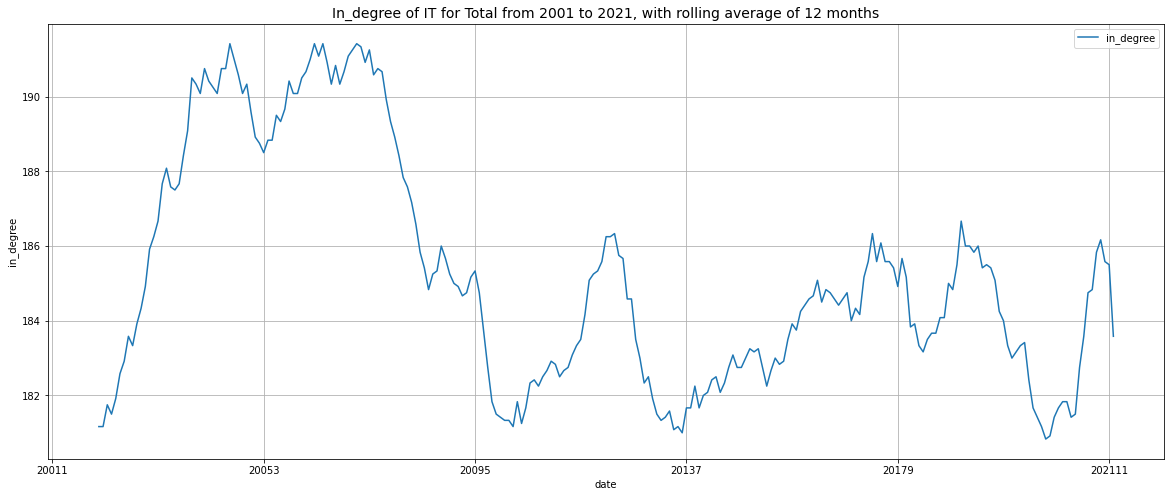

In [66]:
g.plot_cat_ts(full_metrics_df,"TO","in_degree","IT",moving_avg=12,log=False)

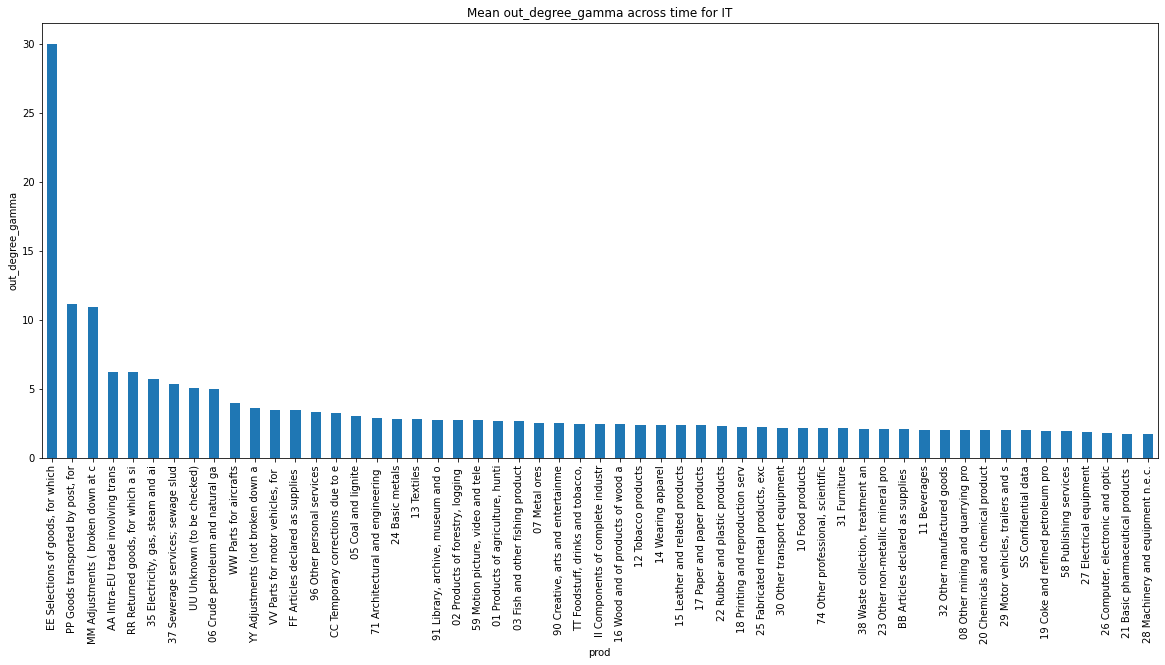

In [67]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="out_degree_gamma",log=False)

### Plots

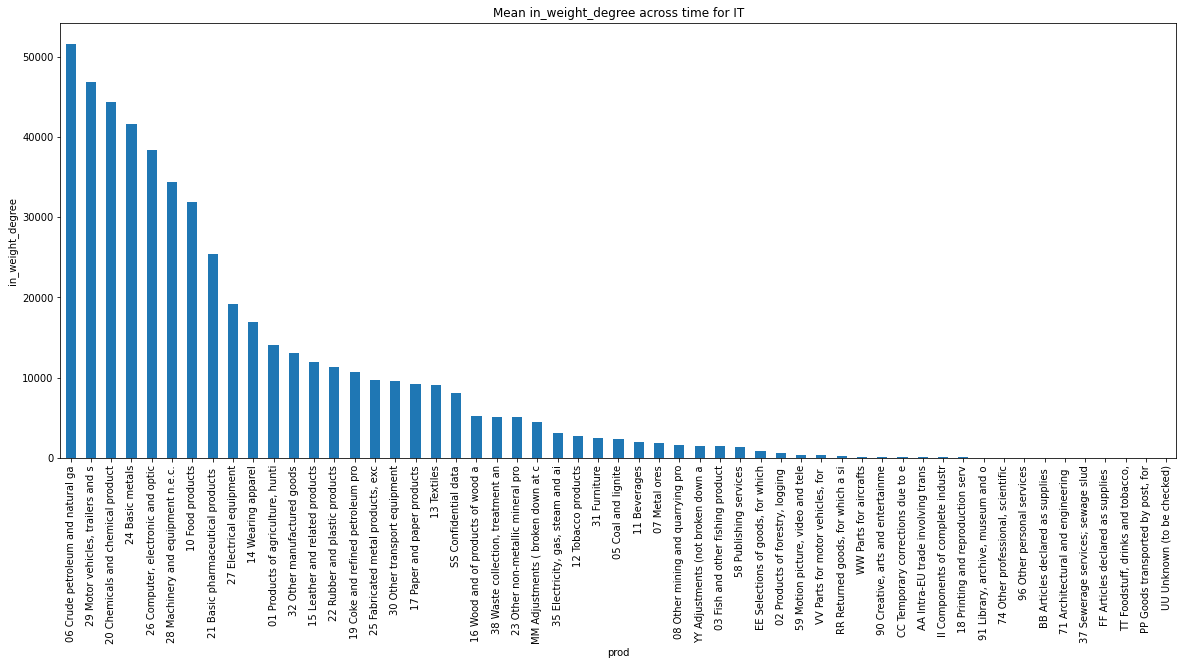

In [ ]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="in_weight_degree",log=False)

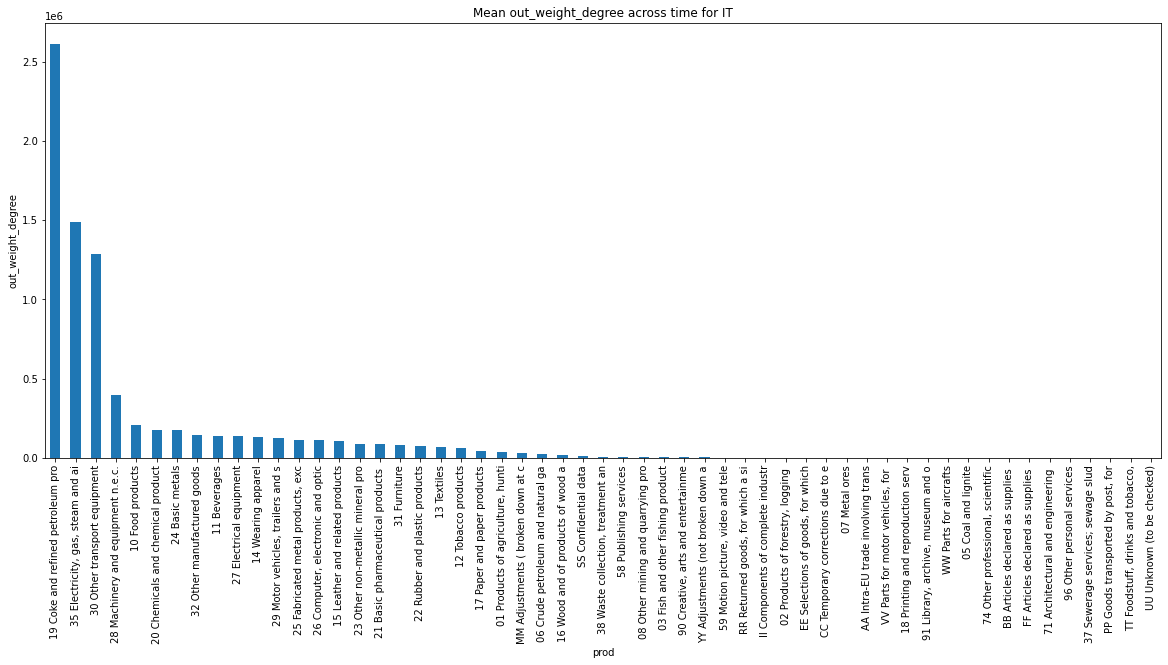

In [ ]:
g.plot_bar_metr(full_metrics_df,country="IT",metr="out_weight_degree",log=False)

### Natural Gas and Petroleum for Italy

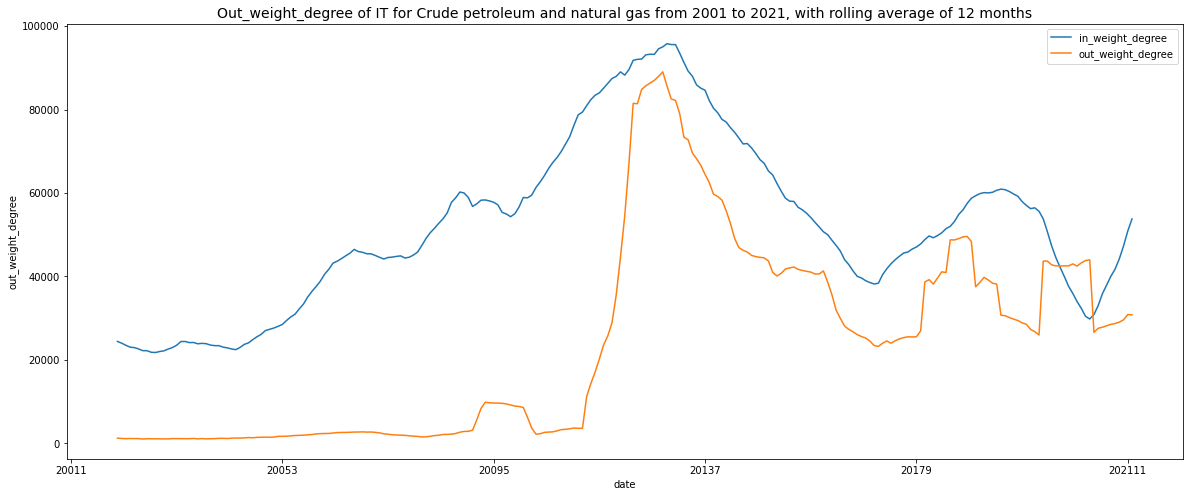

In [68]:
g.plot_cat_ts(full_metrics_df,metr="in_weight_degree",prod="06",moving_avg=12,country="IT")
g.plot_cat_ts(full_metrics_df,metr="out_weight_degree",prod="06",moving_avg=12,country="IT")
# plt.ylabel("weight_degree")
# plt.title("weight_degree"+" over time of "+g.get_cat_name("full","06")+" for "+"IT")
plt.grid()
# plt.legend()
# plt.show()

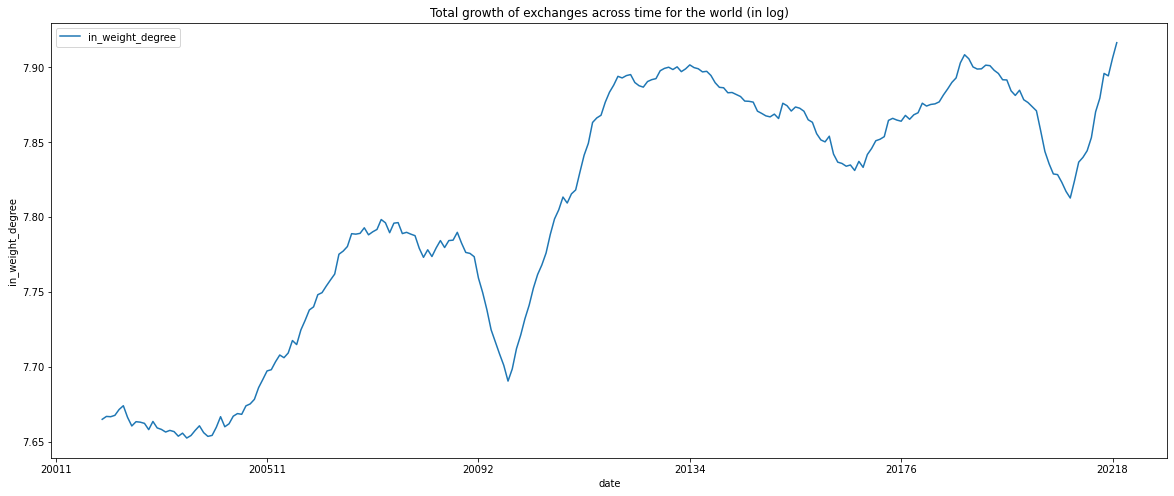

In [76]:
g.plot_cat_ts(full_metrics_df,metr="in_weight_degree",prod="TO",moving_avg=12,log=True)
# g.plot_cat_ts(full_metrics_df,metr="out_weight_abs",prod="TO",moving_avg=12,log=True)
plt.grid()
plt.title("Total growth of exchanges across time for the world (in log)")
plt.show()

### 2012

In [77]:
df_full_2012, _ = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[2012], months=[1,2,3,4,5,6], product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded


In [78]:
df_12_52, _ = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[2012], months=None, product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded


In [ ]:
# df_full_2012.to_parquet("./data-samples/manual/full/df_full_2012_06.parquet")
# df_full_2012 = pd.read_parquet("./data-samples/manual/full/df_full_2012_06.parquet")

In [80]:
# df_12_52[df_12_52.DECLARANT_ISO.isin(["IT","DE","FR"])&df_12_52.PARTNER_ISO.isin(["IT","FR","DE"])].sort_values("PERIOD")

In [81]:
#@title
# df_full_2012[(df_full_2012.DECLARANT_ISO.isin(["IT","HR"]))&df_full_2012.PARTNER_ISO.isin(["IT","HR"])].sort_values(["PERIOD","FLOW"])

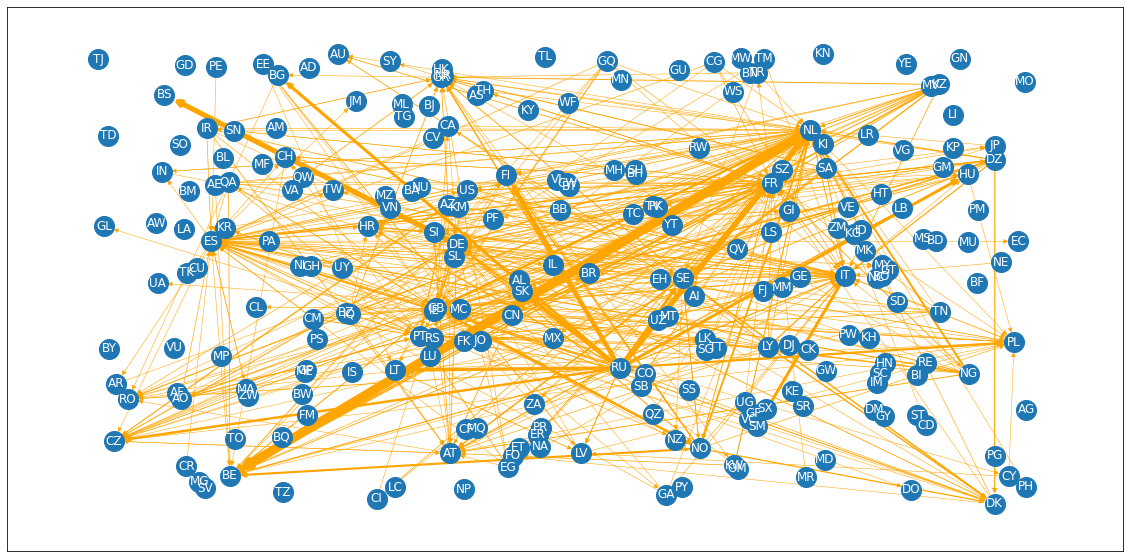

In [82]:
df_full_2012_scaled = g.extract_table_for_graph(df_full_2012,y="2012",scale_by="population",pop_df=df_pop)
coord, metrics, G = g.makeGraph(df_full_2012_scaled, tab_nodes=g.get_world_countries(df_pop, eu_iso, year=df_full_2012_scaled.columns.name),\
                                weight_flag=True, compute_layout=True)
plt.figure(figsize=(20,10))
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
edg_color = [(i/max(edg_color))*256 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/30+0.5 for i in edg_color], font_color="white", node_size=400)
plt.show()